# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

**Empresa:** CallMeMaybe

**Objetivo:** desarrollar una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces
    
 *Ineficiencia:* gran cantidad de llamadas entrantes perdidas (internas y externas), tiempo de espera prolongado para las llamadas entrantes y pocas llamadas salientes

**Objetivos específicos:**
- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

**Datos:** Uso del servicio de telefonía virtual y datos de los clientes.

**Clientes:** Organizaciones con gran cantidad de llamadas entrantes y salientes

**Stakeholders impactados:**


- Supervisores: Ya que ahora podran tener una herramienta que les facilite verificar la eficiencia de sus operadores

- Operadores: Quienes son los directamente evaluados con estas metricas 

- Area informatica: ya que podrian requerirse mejoras a nivel de la plataforma 

- Clientes: Quienes reciben el servicio y esperan contar con un servicio de calidad

## 1. Identificación del problema de negocio

Al ser un servicio de telefonía virtual gestionando llamadas para diferentes empresas, el factor eficiencia es su indicador principal de calidad. Para poder garantizar que se esta brindando un buen servicio, es indispensable conocer los tiempos de espera, si se esta dando una atención oportuna y si el flujo de llamadas este teniendo lugar de manera correcta. 
Todo este proceso se lleva a cabo a través de los operadores y lo que se quiere lograr con este analisis de datos, es encontrar cuales de esos operadores estan afectando la calidad del servicio ya que aún no tienen un medio para identificarlos.

## 2. Descripción de los datos

In [2]:
# cargar los datos
import pandas as pd

telecom = pd.read_csv('telecom_dataset_new.csv')
telecom.info()
telecom.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [3]:
# valores nulos de operator_id
print('cantidad de valores nulos de operator_id:', telecom['operator_id'].isna().sum())
print('cantidad de clientes reportados en los datos:', telecom['user_id'].nunique())
print('filas duplicadas:', telecom.duplicated().sum())
print('rango de tiempo medido: desde', telecom['date'].min(), 'hasta: ', telecom['date'].max())


cantidad de valores nulos de operator_id: 8172
cantidad de clientes reportados en los datos: 307
filas duplicadas: 4900
rango de tiempo medido: desde 2019-08-02 00:00:00+03:00 hasta:  2019-11-28 00:00:00+03:00


In [4]:
# Segundo df
clientes = pd.read_csv('telecom_clients.csv')
clientes.info()
clientes.head()
print('duplicados:', clientes.duplicated().sum())
print('rango de tiempo medido: desde', clientes['date_start'].min(), 'hasta: ', clientes['date_start'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
duplicados: 0
rango de tiempo medido: desde 2019-08-01 hasta:  2019-10-31


**Observaciones:**

Tenemos dos dataframe: 
- el primero con la información del servicio con 53902 filas y 9 columnas. En cuanto a la calidad de los datos tenemos 8172 valores nulos para la columna opertator_id. Un formato para date e internal que debe ser corregido. 4900 filas duplicadas.
- El segundo cuenta con la información de 732 clientes, sin valores nulos, sin valores duplicados y el formato para date que debe ser corregido. 
- Ambos con fechas entre febrero y octubre del 2019, incluyendo el primer df los datos de noviembre.

**variables de interés:**
- Tiempo de espera (calculado con las columnas duracion total de la llamada y duración de la llamada)
- Llamada perdida: determinante de eficacia
- dirección: me da la cantidad de llamadas salientes
- operator_id: para poder identificar quienes son los operadores ineficaces (requiere de un cambio de formato a entero y un análisis de los valores duplicados para saber exactamente la cantidad de valores nulos, para posteriormente transformarlos, ya que su eliminación podría quitarnos información relevante para la identificacion de los operadores ineficaces)
- tipo de plan: para saber si esta relacionado con alguna variable de ineficiencia

## 3. Procesamiento y limpieza de los datos 
 - Corregir formatos de columnas
- Verificar valores nulos en la columna operador_id
- Eliminar duplicados
- Crear columna waiting_time 

### 3.1. Formato correcto 

In [5]:
# pasar datos a formato correcto 
telecom['date']= pd.to_datetime(telecom['date'])
telecom['internal'] = telecom['internal'].astype(bool)
telecom['operator_id'] = telecom['operator_id'].astype('Int64')
telecom.info()

clientes['date_start'] = pd.to_datetime(clientes['date_start'])
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53902 non-null  bool                     
 4   operator_id          45730 non-null  Int64                    
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
dtypes: Int64(1), bool(2), datetime64[ns, UTC+03:00](1), int64(4), object(1)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIn

### 3.2. Analisis y corrección de valores nulos 

In [6]:
# valores nulos por dirección

telecom[telecom['operator_id'].isna()]['direction'].value_counts() 


direction
in     7972
out     200
Name: count, dtype: int64

In [7]:
# valores nulos por llamadas perdidas

telecom[telecom['operator_id'].isna()]['is_missed_call'].value_counts()


is_missed_call
True     8050
False     122
Name: count, dtype: int64

**Observaciones:** Podemos ver que la mayoria de filas con valores nulos en la columna 'operator_id' son de llamadas perdidas entrantes, es decir, tal vez no alcanzaron a ser asignadas a un operador, lo cual nos podria tambien estar indicando una falla en la eficiencia dle servicio, ms no un error en los datos. 

### 3.3. Manejo de duplicados

In [8]:
# analisis de duplicados 
telecom[telecom.duplicated(keep=False)].head()


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50
8,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50
27,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
28,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
38,166377,2019-08-14 00:00:00+03:00,in,False,<NA>,True,1,0,3


**Observaciones:** Aca podemos ver que los 4900 duplicados no nos aportan información adicional y si estaria afectando nuestro analisis posterior, por lo tanto las eliminaremos.

In [9]:
telecom = telecom.drop_duplicates()
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              49002 non-null  int64                    
 1   date                 49002 non-null  datetime64[ns, UTC+03:00]
 2   direction            49002 non-null  object                   
 3   internal             49002 non-null  bool                     
 4   operator_id          41546 non-null  Int64                    
 5   is_missed_call       49002 non-null  bool                     
 6   calls_count          49002 non-null  int64                    
 7   call_duration        49002 non-null  int64                    
 8   total_call_duration  49002 non-null  int64                    
dtypes: Int64(1), bool(2), datetime64[ns, UTC+03:00](1), int64(4), object(1)
memory usage: 3.1+ MB


### 3.4. Columna waiting_time

In [10]:
telecom['waiting_time'] = telecom['total_call_duration'] - telecom['call_duration']
telecom.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,25


## 4. Hipotesis a validar

Tenemos 3 grandes indicadores de ineficiencia entre los operadores, por lo tanto propongo las siguientes hipotesis:

1. H0: No existe diferencia significativa en la proporción de llamadas entrantes perdidas entre operadores

2. H0: El tiempo de espera promedio de las llamadas entrantes es igual para todos los operadores

3. H0: No existe diferencia significativa entre operadores en la cantidad promedio de llamadas salientes

4. H0: No existe correlación entre el tiempo de espera y la tasa de llamadas perdidas.

### 4.1. Hipotesis: No existe diferencia significativa en la proporción de llamadas entrantes perdidas entre operadores

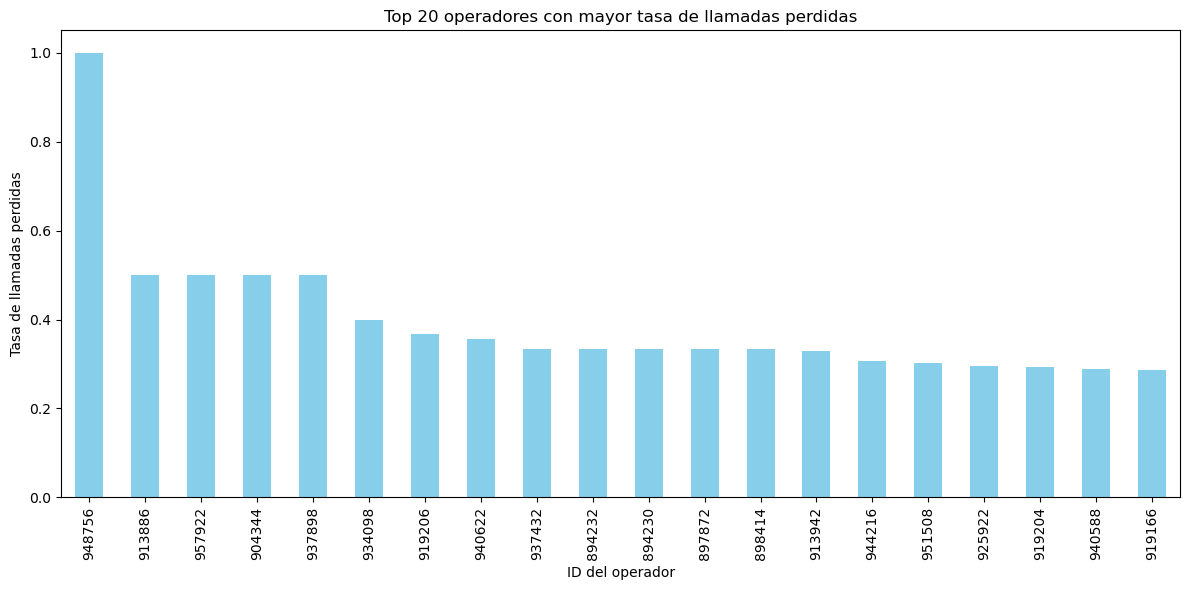

In [11]:
import matplotlib.pyplot as plt

# Filtrar solo llamadas entrantes
entrantes = telecom[telecom['direction'] == 'in']

missed_rate = entrantes.groupby('operator_id')['is_missed_call'].mean().sort_values()

top20 = missed_rate.sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
top20.plot(kind='bar', color="skyblue")
plt.title('Top 20 operadores con mayor tasa de llamadas perdidas')
plt.xlabel('ID del operador')
plt.ylabel('Tasa de llamadas perdidas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

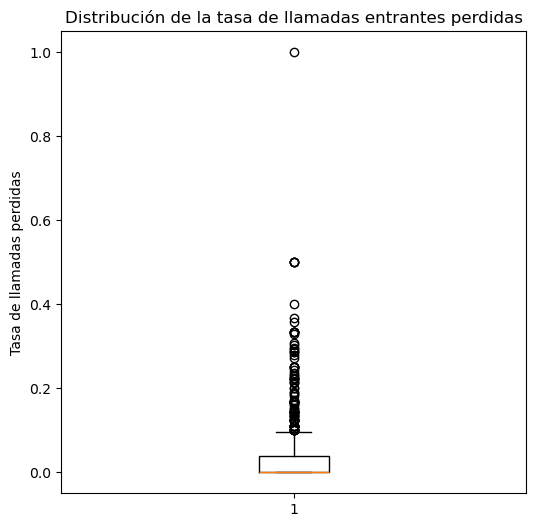

In [12]:
# Distribución de los datos

plt.figure(figsize=(6,6))
plt.boxplot(missed_rate.dropna())
plt.title('Distribución de la tasa de llamadas entrantes perdidas')
plt.ylabel('Tasa de llamadas perdidas')
plt.show()

**Observaciones:** Al identificar las llamadas perdidas entrantes por operador, vemos que tenemos un número muy grande de operadores y la mayoria de ellos tienen una tasa de 0. por lo tanto, escogimos el top 20 para poder identificar sin problema a nuestros operadores ineficientes.

#### 4.1.1. Prueba de hipotesis 

In [13]:
import scipy.stats as st

contingency = pd.crosstab(entrantes['operator_id'], entrantes['is_missed_call'])

alpha = 0.05

chi2, pvalue, dof, expected = st.chi2_contingency(contingency)

print("pvalue:", pvalue)

if pvalue < alpha:
    print("Rechazamos la hipótesis nula: existen diferencias significativas entre operadores.")
else:
    print("No podemos rechazar la hipótesis nula: no hay evidencia de diferencias entre operadores.")

pvalue: 1.240560176448891e-44
Rechazamos la hipótesis nula: existen diferencias significativas entre operadores.


### 4.2. Hipotesis: El tiempo de espera promedio de las llamadas entrantes es igual para todos los operadores

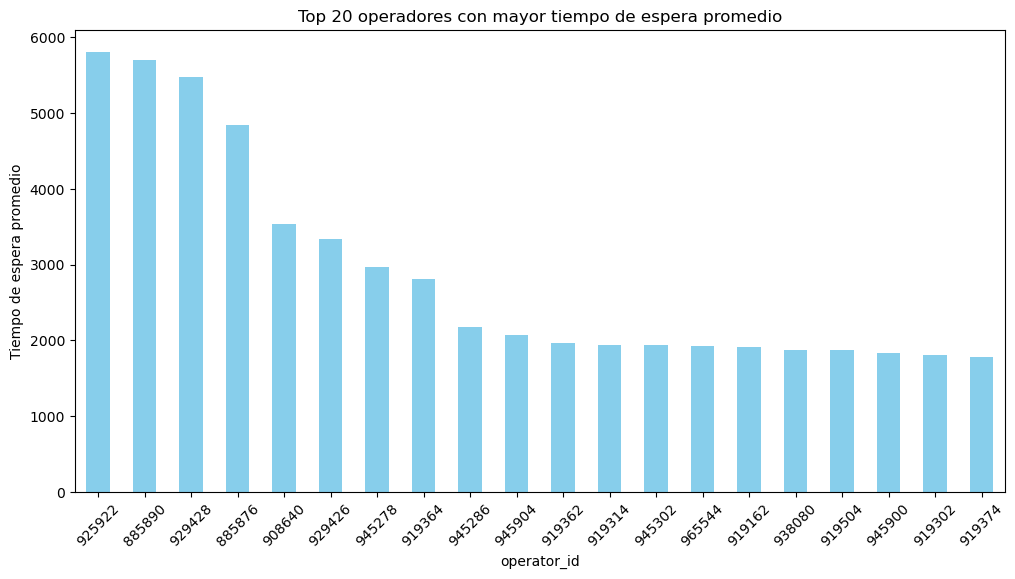

In [14]:
import seaborn as sns

# Agrupación
wait_means = telecom.groupby("operator_id")["waiting_time"].mean().sort_values(ascending=False)

# Selección top 20
top_n = wait_means.head(20)

# Gráfico
plt.figure(figsize=(12,6))
top_n.plot(kind="bar", color="skyblue")
plt.title("Top 20 operadores con mayor tiempo de espera promedio")
plt.xlabel("operator_id")
plt.ylabel("Tiempo de espera promedio")
plt.xticks(rotation=45)
plt.show()


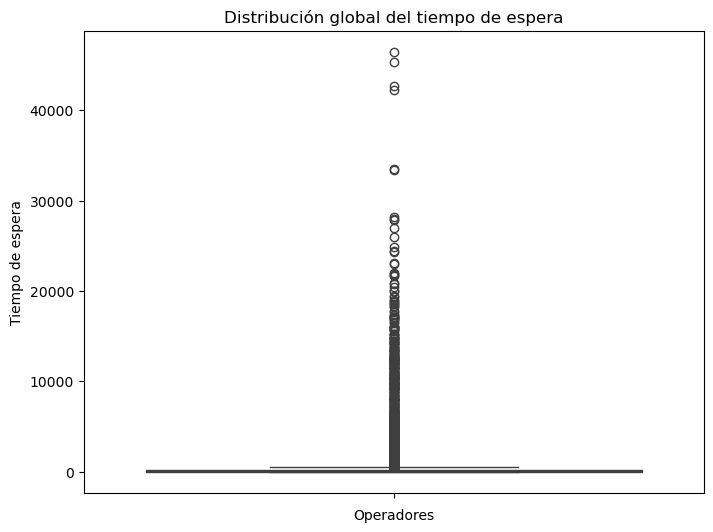

In [15]:
# Distribución de los dats
plt.figure(figsize=(8,6))
sns.boxplot(y=telecom["waiting_time"])
plt.title("Distribución global del tiempo de espera")
plt.ylabel("Tiempo de espera")
plt.xlabel('Operadores')
plt.show()

**Observciones:** Dado que el número total de operadores es muy alto, se visualizan únicamente los 20 con mayor tiempo de espera promedio para facilitar su interpretación. Tambien observamos que la mayoría de operadores se manejan dentro de un tiempo promedio de espera de 0.

####  4.2.1. Prueba de hipotesis

In [16]:
groups = []
for operator_id, group in entrantes.groupby('operator_id'):
    groups.append(group['waiting_time'].dropna().values)

# prueba estadistica de hipotesis
alpha = 0.05

f_stat, pvalue = st.f_oneway(*groups)

print("pvalue:", pvalue)

if pvalue < alpha:
    print("Rechazamos la hipótesis nula: existen diferencias significativas en el tiempo de espera entre operadores.")
else:
    print("No podemos rechazar la hipótesis nula: no hay evidencia de diferencias en el tiempo de espera.")


pvalue: 0.0
Rechazamos la hipótesis nula: existen diferencias significativas en el tiempo de espera entre operadores.


### 4.3. Hipotesis: No existe diferencia significativa entre operadores en la cantidad promedio de llamadas salientes

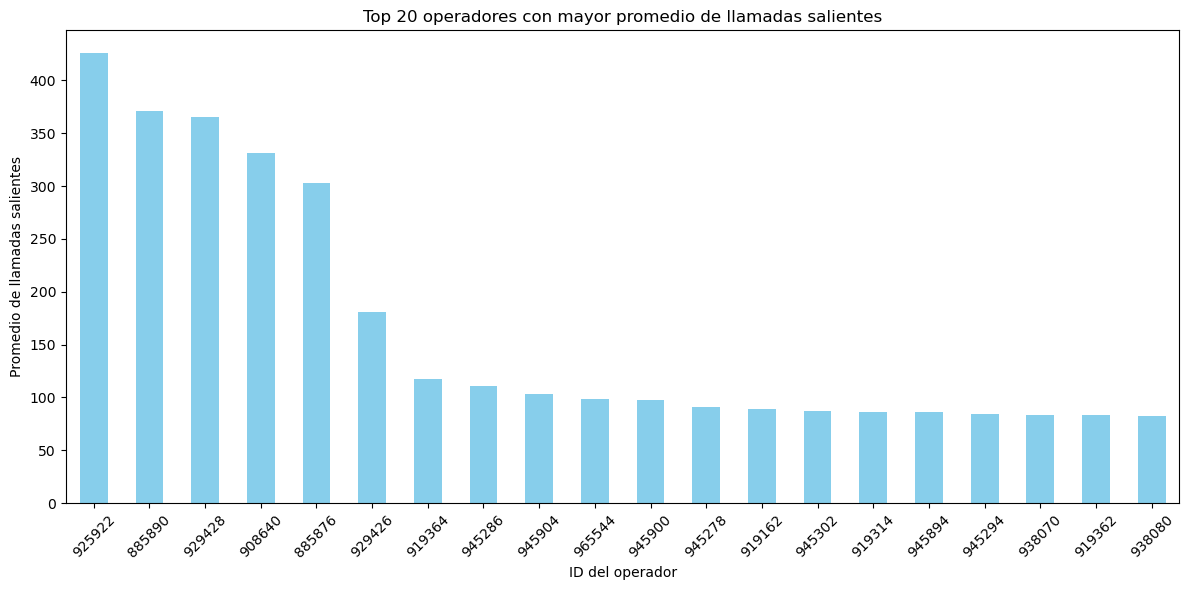

In [17]:
#separamos los datos
out_calls = telecom[telecom["direction"] == "out"]

# Agrupación 
avg_out = out_calls.groupby("operator_id")["calls_count"].mean().sort_values(ascending=False)

top20_out = avg_out.head(20)

plt.figure(figsize=(12,6))
top20_out.plot(kind="bar", color="skyblue")

plt.title("Top 20 operadores con mayor promedio de llamadas salientes")
plt.xlabel("ID del operador")
plt.ylabel("Promedio de llamadas salientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


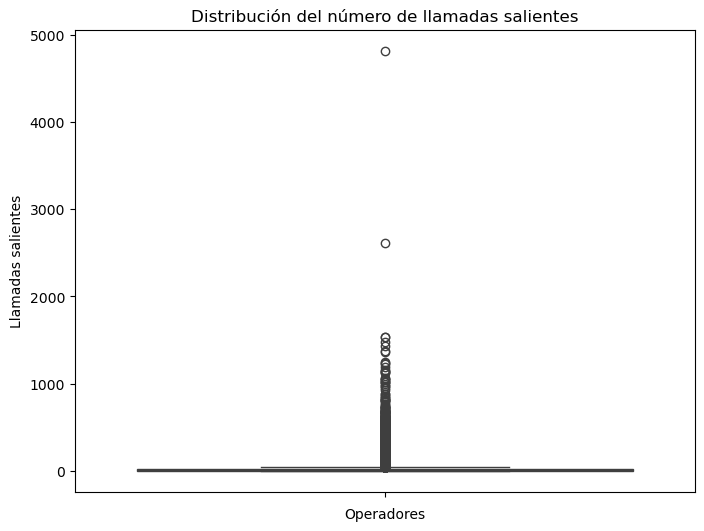

In [18]:
# Boxplot de llamadas salientes 
plt.figure(figsize=(8,6))
sns.boxplot(y=out_calls['calls_count'])
plt.title("Distribución del número de llamadas salientes")
plt.ylabel("Llamadas salientes")
plt.xlabel('Operadores')
plt.show()

#### 4.3.1. Prueba de hipotesis

In [19]:
groups = [
    group["calls_count"].values
    for operator_id, group in out_calls.groupby("operator_id")
    if len(group) > 1
]

alpha = 0.05

anova_results = st.f_oneway(*groups)

print("p-value:", anova_results.pvalue)

if anova_results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: existen diferencias significativas.")
else:
    print("No podemos rechazar la hipótesis nula: no hay evidencia de diferencias.")

p-value: 0.0
Rechazamos la hipótesis nula: existen diferencias significativas.


### 4.4. Hipotesis: No existe correlación entre el tiempo de espera y la tasa de llamadas perdidas

In [20]:
# Establecimiento de metricas

wait_mean = telecom.groupby("operator_id")["waiting_time"].mean()
entrantes 
missed_rate

#creamos nuestro nuevo df
cor_data = pd.concat([wait_mean, missed_rate], axis=1)
cor_data.columns = ["wait_mean", "missed_rate"]
cor_data = cor_data.dropna()
cor_data


,wait_mean,missed_rate
operator_id,,
879896,104.914530,0.0
879898,457.696035,0.0
880020,14.000000,0.0
880022,53.971429,0.0
880026,121.978022,0.0
...,...,...
971102,338.000000,0.0
971354,42.000000,0.0
972412,210.000000,0.0


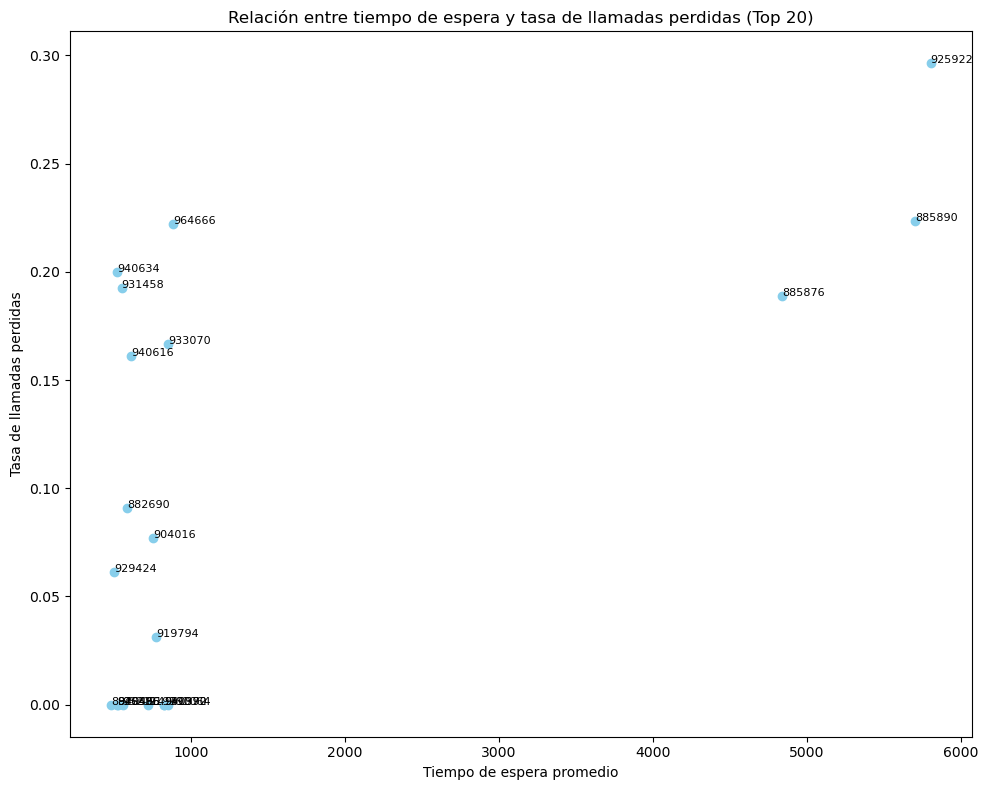

In [21]:
# Escogemos solo el top 20 

top20 = cor_data.sort_values("wait_mean", ascending=False).head(20)

#Gráfico

plt.figure(figsize=(10,8))
plt.scatter(top20["wait_mean"], top20["missed_rate"], color="skyblue")

for op in top20.index:
    plt.text(
        top20.loc[op, "wait_mean"],
        top20.loc[op, "missed_rate"],
        str(op),
        fontsize=8
    )

plt.title("Relación entre tiempo de espera y tasa de llamadas perdidas (Top 20)")
plt.xlabel("Tiempo de espera promedio")
plt.ylabel("Tasa de llamadas perdidas")
plt.tight_layout()
plt.show()


**Observaciones:** Vemos que la mayoría de los operadores tienen una tasa de llamadas perdidas de 0 y operadores con metricas atipicas que generan que nuestra escala se modifique. Sin embargo, considero importante mantenerlos en el gráfico ya que son estos operadores ineficientes los que queremos identificar.

#### 4.4.1. Prueba de hipotesis

In [22]:
from scipy.stats import spearmanr

alpha = 0.05

corr_coef, pval = spearmanr(cor_data["wait_mean"], cor_data["missed_rate"])

print("Coeficiente de correlación de Spearman:", corr_coef)
print("p-value:", pval)

if pval < alpha:
    print("Rechazamos la hipótesis nula: existe una correlación significativa.")
else:
    print("No podemos rechazar la hipótesis nula: no existe evidencia de correlación.")


Coeficiente de correlación de Spearman: 0.31430380479956843
p-value: 9.470525384995195e-19
Rechazamos la hipótesis nula: existe una correlación significativa.


## 5. Correlación entre KPIs

In [23]:
# Traemos todos los KPIs evaluados

# KPI 1: tasa de llamadas perdidas
missed_rate

# KPI 2: tiempo de espera
waiting_time_mean = telecom.groupby("operator_id")["waiting_time"].mean()

# KPI 3: llamadas salientes por operador

avg_out

# KPI 4: duración promedio
duration_mean = telecom.groupby("operator_id")["call_duration"].mean()



### 5.1. Tabla comparativa de KPI por operador

In [24]:
#DF de KPIs

kpi_df = pd.DataFrame({
    "missed_rate": missed_rate,
    "waiting_time_mean": waiting_time_mean,
    "avg_out_calls": avg_out,
    "duration_mean": duration_mean
})

kpi_df = kpi_df.dropna()
kpi_df


,missed_rate,waiting_time_mean,avg_out_calls,duration_mean
operator_id,,,,
879896,0.0,104.914530,9.083333,545.829060
879898,0.0,457.696035,42.405882,1133.881057
880020,0.0,14.000000,2.923077,112.250000
880022,0.0,53.971429,3.048387,216.385714
880026,0.0,121.978022,13.463415,842.450549
...,...,...,...,...
970244,0.0,32.333333,1.000000,49.333333
970252,0.0,33.666667,2.500000,48.333333
970254,0.0,63.000000,2.250000,45.800000


In [25]:
# Matriz de correlación entre los KPIs

corr_matrix = kpi_df.corr()
corr_matrix

,missed_rate,waiting_time_mean,avg_out_calls,duration_mean
missed_rate,1.000000,0.199459,0.189191,0.273352
waiting_time_mean,0.199459,1.000000,0.981943,0.915669
avg_out_calls,0.189191,0.981943,1.000000,0.882956
duration_mean,0.273352,0.915669,0.882956,1.000000


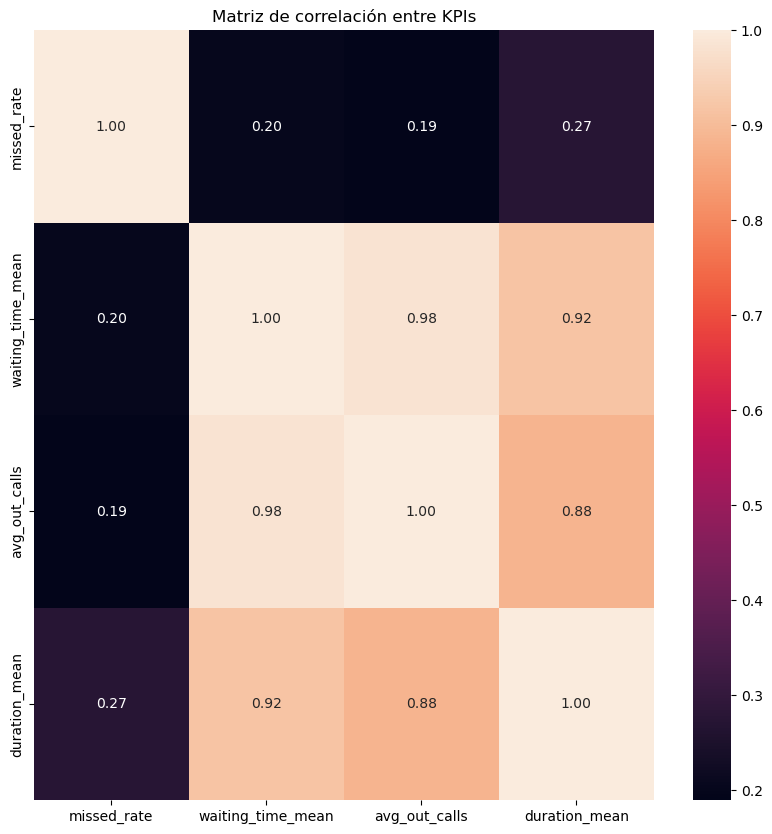

In [26]:
# heatmap
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Matriz de correlación entre KPIs")
plt.show()

**Observaciones:** 
1. missed_rate: Tiene correlaciones bajas con todos los demás KPIs (entre 0.19 y 0.27), esto quiere decir que no depende fuertemente ni del tiempo de espera, ni de la duración de las llamadas, ni del volumen de llamadas salientes.

2. waiting_time_mean: Altamente correlacionado con: avg_out_calls (0.98) y duration_mean (0.92). Esto quiere decir que cuando el tiempo de espera sube, también suben las llamadas salientes y la duración media. Lo cual sugiere una carga operativa alta: cuando los agentes están saturados, todo se alarga.

3. avg_out_calls: 
Altamente correlacionado con waiting_time_mean (0.98) y duration_mean (0.88). Esto quiere decir que un mayor número de llamadas salientes está fuertemente asociado con más tiempo de espera y llamadas más largas. Puede sugierir que los operadores compensan tiempos muertos llamando, pero cuando el volumen sube, se satura el sistema.

4. duration_mean: Altamente correlacionado con waiting_time_mean (0.92) y avg_out_calls (0.88). Esto quiere decir que  entre más llamadas y más duración, se genera más espera tambien.

**Conclusión**

Vemos que nuestros KPIs estan fuertemente conectados: waiting_time_mean, avg_out_calls y duration_mean. Por lo tanto, si quieremos impactar en alguno de ellos, seguramente movera los otros indicadores y métricas. POr otro lado el indicador de llamadas perdidas funciona en un sentido más independiente y se podra intervenir sin afectar los demás.

## 6. Dashboard

https://public.tableau.com/views/Operadoresineficientes_17648734388190/Dashboard1?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link